# Hourly Time Series Forecasting using Facebook's Prophet

In this notebook we will use facebook's prophet package to forecast hourly energy use. 

1. Import useful libraries

In [6]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from fbprophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error
plt.style.use('fivethirtyeight') # For plots

# Data
The data we will be using is hourly power consumption data from PJM. Energy consumtion has some unique charachteristics. It will be interesting to see how prophet picks them up.

Pulling the `PJM East` which has data from 2002-2018 for the entire east region.

2. import the data thanks to the following link : ```s3://full-stack-bigdata-datasets/Machine Learning Supervisé/time_series/PJME_hourly.csv``` make sure to use the arguments ```index_col=[0], parse_dates=[0]``` and remove all dates previous to january the first 2008

In [7]:
df = pd.read_csv('s3://full-stack-bigdata-datasets/Machine Learning Supervisé/time_series/PJME_hourly.csv', index_col=[0], parse_dates=[0])

3. Plot the time series

In [8]:
df.head()

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0


<AxesSubplot:xlabel='Datetime', ylabel='PJME_MW'>

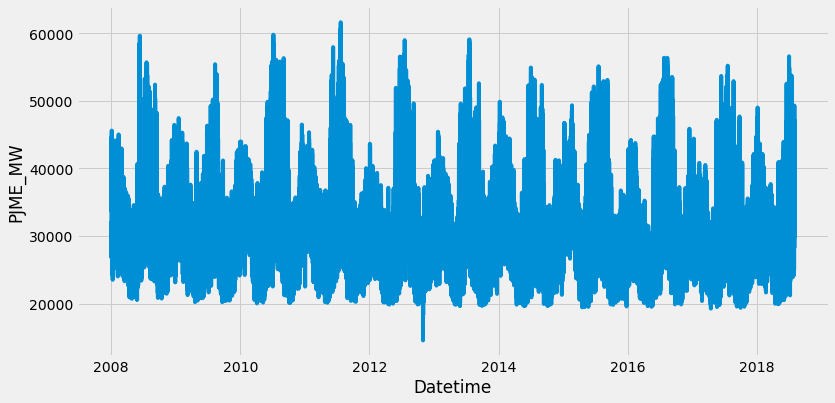

In [16]:
start_date = '2008-01-01'
sample = df[df.index >= start_date]

plt.figure(figsize=(12,6))
sns.lineplot(x=sample.index, y=sample['PJME_MW'], )


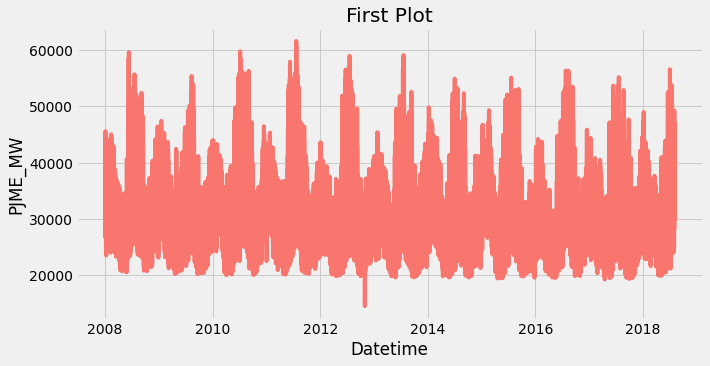

# EDA

4. Create this collection of new variables :
* ```date``` equal to the index
* ```hour``` equal to the hour of the day
* ```dayofweek```
* ```quarter```
* ```month```
* ```year```
* ```dayofyear```
* ```dayofmonth```
* ```weekofyear```

Create an object X containing the above variables and y containing the time series

In [23]:
copy_df = df.copy()
copy_df['date'] = copy_df.index
copy_df['hour'] = copy_df['date'].dt.hour
copy_df['dayofweek'] = copy_df['date'].dt.dayofweek
copy_df['quarter'] = copy_df['date'].dt.quarter
copy_df['month'] = copy_df['date'].dt.month
copy_df['year'] = copy_df['date'].dt.year
copy_df['dayofyear'] = copy_df['date'].dt.dayofyear
copy_df['dayofmonth'] = copy_df['date'].dt.day
copy_df['weekofyear'] = copy_df['date'].dt.isocalendar().week
copy_df.head()

,PJME_MW,date,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
Datetime,,,,,,,,,,
2002-12-31 01:00:00,26498.0,2002-12-31 01:00:00,1,1,4,12,2002,365,31,1
2002-12-31 02:00:00,25147.0,2002-12-31 02:00:00,2,1,4,12,2002,365,31,1
2002-12-31 03:00:00,24574.0,2002-12-31 03:00:00,3,1,4,12,2002,365,31,1
2002-12-31 04:00:00,24393.0,2002-12-31 04:00:00,4,1,4,12,2002,365,31,1
2002-12-31 05:00:00,24860.0,2002-12-31 05:00:00,5,1,4,12,2002,365,31,1


5. Create an object features_and_target containing both and display the first few lines

In [24]:
new_cols=['hour','dayofweek','quarter','month','year','dayofyear','dayofmonth','weekofyear','PJME_MW']

In [25]:
features_and_target=copy_df.loc[:,new_cols]

In [26]:
features_and_target.head()

,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,PJME_MW
Datetime,,,,,,,,,
2002-12-31 01:00:00,1,1,4,12,2002,365,31,1,26498.0
2002-12-31 02:00:00,2,1,4,12,2002,365,31,1,25147.0
2002-12-31 03:00:00,3,1,4,12,2002,365,31,1,24574.0
2002-12-31 04:00:00,4,1,4,12,2002,365,31,1,24393.0
2002-12-31 05:00:00,5,1,4,12,2002,365,31,1,24860.0


## Plotting the Features to see trends

6. Plot the time series against hour, dayofweek, year, weekofyear


In [46]:
features_and_target.describe()

,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,PJME_MW
count,145366.000000,145366.000000,145366.000000,145366.000000,145366.000000,145366.000000,145366.000000,145366.000000,145366.000000
mean,11.501596,2.999003,2.481240,6.435948,2009.801026,180.459378,15.723161,26.218600,32080.222831
std,6.921794,1.999503,1.114423,3.438946,4.791823,105.137240,8.801210,15.019719,6464.012166
min,0.000000,0.000000,1.000000,1.000000,2002.000000,1.000000,1.000000,1.000000,14544.000000
25%,6.000000,1.000000,1.000000,3.000000,2006.000000,90.000000,8.000000,13.000000,27573.000000
50%,12.000000,3.000000,2.000000,6.000000,2010.000000,179.000000,16.000000,26.000000,31421.000000
75%,18.000000,5.000000,3.000000,9.000000,2014.000000,271.000000,23.000000,39.000000,35650.000000
max,23.000000,6.000000,4.000000,12.000000,2018.000000,366.000000,31.000000,53.000000,62009.000000


<AxesSubplot:xlabel='hour', ylabel='PJME_MW'>

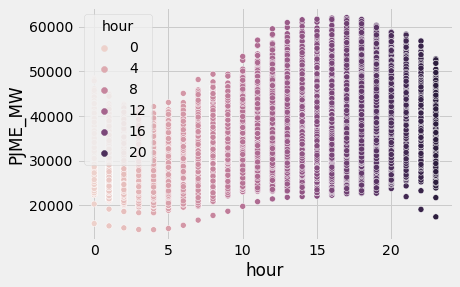

In [42]:
sns.scatterplot(data=features_and_target, x='hour', y='PJME_MW', hue='hour')

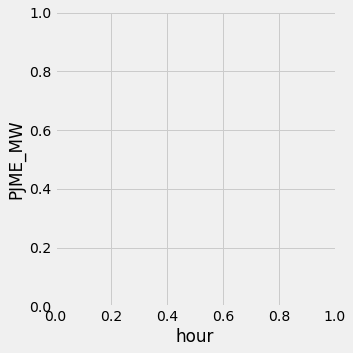

In [44]:
#plt.figure(figsize=(20,8))
sns.set_palette(sns.color_palette("mako"))
sns.pairplot(data=features_and_target, x_vars=['hour'], y_vars='PJME_MW', 
              palette="rocket", height=5,
            plot_kws={'alpha':0.15, 'linewidth':0})


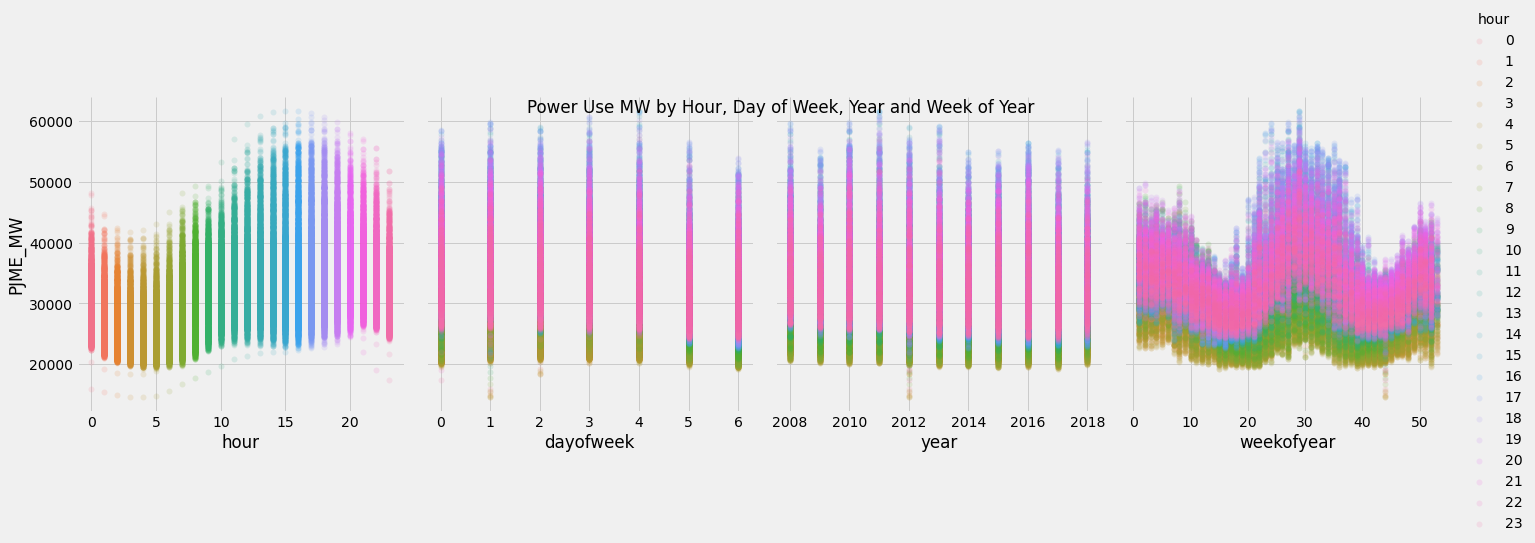

# Train/Test Split
7. Cut off the data after 2015 to use as our validation set. We will train on earlier data.

8. plot the series with different colors for the train and test set to visualize the separation.

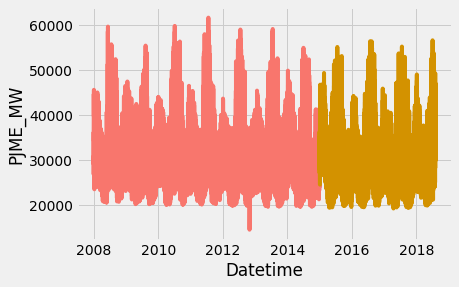

# Simple Prophet Model
9. In pjme_train rename the Datetime variable "ds" and PJME_MW "y" to fit into the Prophet framework

,ds,y
0,2008-01-01 00:00:00,30998.0
1,2008-12-31 01:00:00,28937.0
2,2008-12-31 02:00:00,27714.0
3,2008-12-31 03:00:00,27120.0
4,2008-12-31 04:00:00,26995.0


10. Create an instance of the Prophet model and fit it on the train data.

11. Make predictions with your trained default prophet model on the test set

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2015-01-01 01:00:00,30852.264903,25635.915422,34524.632081,30852.264903,30852.264903,-980.448780,-980.448780,-980.448780,-4351.662841,-4351.662841,-4351.662841,1236.772123,1236.772123,1236.772123,2134.441938,2134.441938,2134.441938,0.0,0.0,0.0,29871.816123
1,2015-01-01 02:00:00,30852.144512,23979.776594,32571.547659,30852.144512,30852.144512,-2455.259833,-2455.259833,-2455.259833,-5821.016459,-5821.016459,-5821.016459,1228.651860,1228.651860,1228.651860,2137.104766,2137.104766,2137.104766,0.0,0.0,0.0,28396.884680
2,2015-01-01 03:00:00,30852.024122,22795.310363,31985.799038,30852.024122,30852.024122,-3310.968355,-3310.968355,-3310.968355,-6669.960453,-6669.960453,-6669.960453,1219.198853,1219.198853,1219.198853,2139.793245,2139.793245,2139.793245,0.0,0.0,0.0,27541.055766
3,2015-01-01 04:00:00,30851.903731,22944.591704,32016.622524,30851.903731,30851.903731,-3436.525019,-3436.525019,-3436.525019,-6787.554416,-6787.554416,-6787.554416,1208.522021,1208.522021,1208.522021,2142.507377,2142.507377,2142.507377,0.0,0.0,0.0,27415.378712
4,2015-01-01 05:00:00,30851.783340,23753.200330,32415.511457,30851.783340,30851.783340,-2745.788987,-2745.788987,-2745.788987,-6087.778302,-6087.778302,-6087.778302,1196.742153,1196.742153,1196.742153,2145.247162,2145.247162,2145.247162,0.0,0.0,0.0,28105.994353


13. Plot the trend, the yearly seasonnality, the weekly seasonnality, and the daily seasonnality.

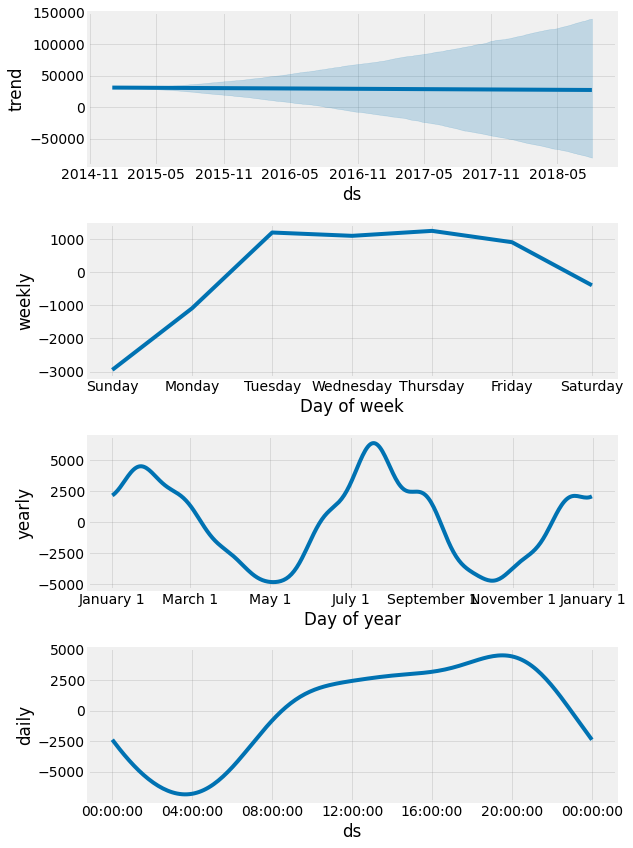

# Compare Forecast to Actuals

14. Plot the forcasts against the actual values in the test set.

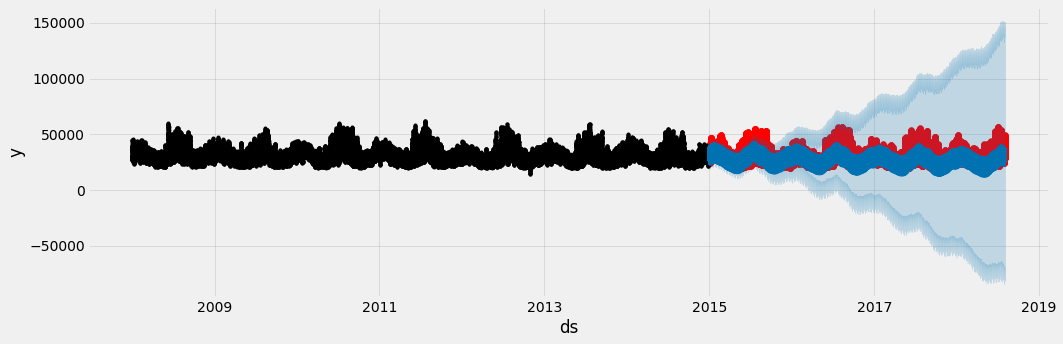

# Look at first month of predictions

15. Compare in a graph predictions for the first month against reality.

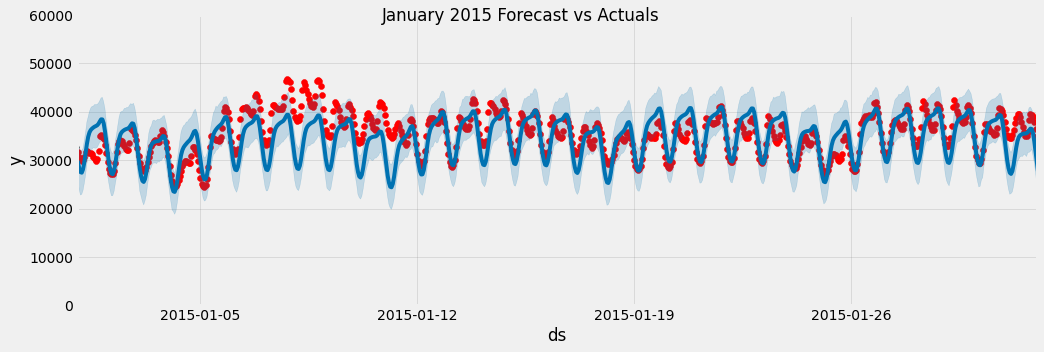

# Single Week of Predictions

16. plot the first week of data against the model's predictions

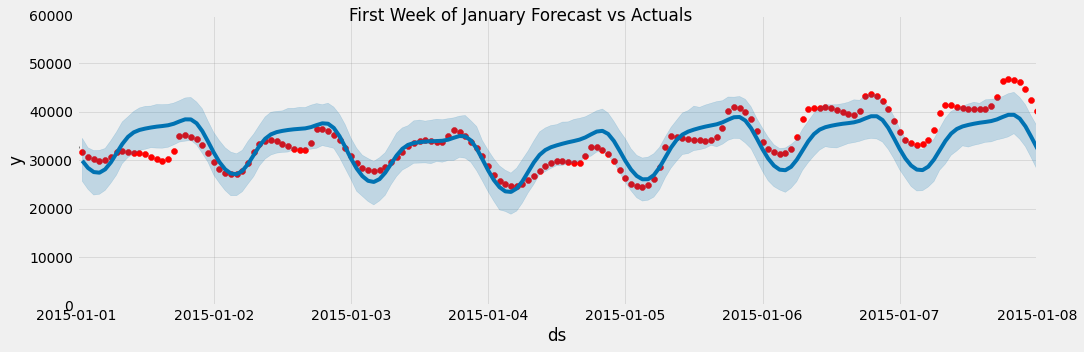

17. Calculate the MSE, the MAE and the MAPE (mean obsolute percentage error) for this model over the test dataset
$$MAPE = \frac{1}{n}\sum_{t=1}^{n}|\frac{Y_t - \hat{Y_t}}{Y_t}|$$

The MSE on the test set is : 
 48914247.70837993


The MAE on the test set is : 
 5462.547286230777


The MAPE on the test set is : 
 16.96548776603218


# Adding Holidays
Next we will see if adding holiday indicators will help the accuracy of the model. Prophet comes with a *Holiday Effects* parameter that can be provided to the model prior to training. 

We will use the built in pandas `USFederalHolidayCalendar` to pull the list of holidays

18. Create a test_holidays object containing the us federal holidays for the considered test period and an object train_holidays for the considered train period.

19. Create a DataFrame contaning all holidays over the observed period with a ds column with the dates and a holiday column with the holidays and convert ds column to datetime format.

,ds,holiday
0,2008-01-01 00:00:00,USFederalHoliday
1,2009-01-01 00:00:00,USFederalHoliday
2,2008-12-25 01:00:00,USFederalHoliday
3,2008-12-25 02:00:00,USFederalHoliday
4,2008-12-25 03:00:00,USFederalHoliday


20. Create an instance of the Prophet model with ```holidays = holiday_df``` the DataFrame we have just created, and train that model on the training set.

## Predict With Holidays

21. Make predictions for the test set with the holiday model

## Plot Holiday Effect

22. Plot the different components of the holiday model

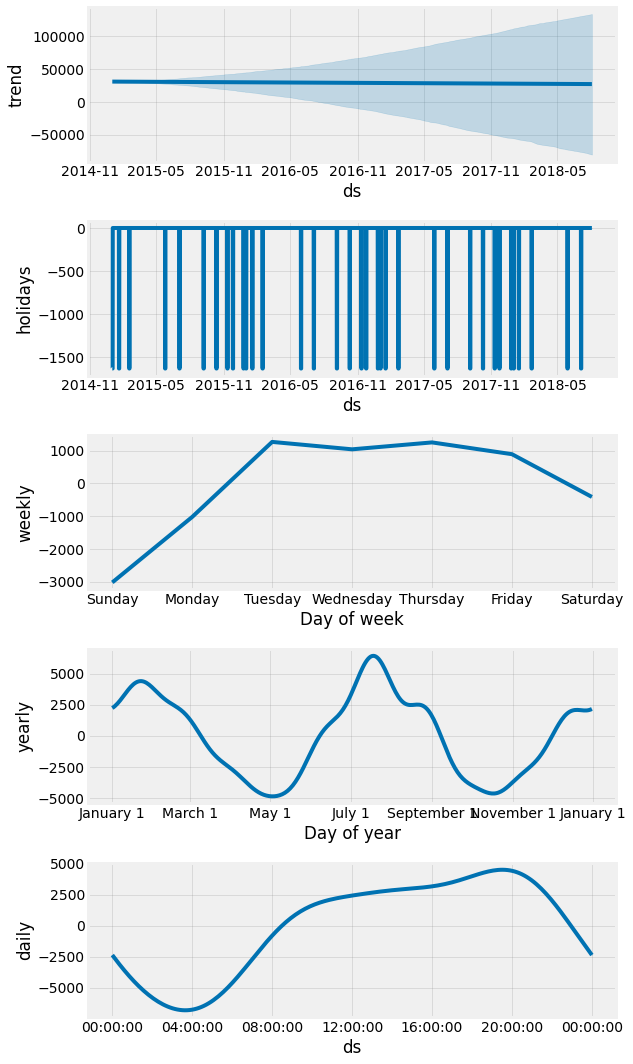

# Error Metrics with Holidays Added
23. Calculate the MSE, MAE and MAPE for the holiday model on the test set.

The MSE on the test set is : 
 48827009.40244012


The MAE on the test set is : 
 5461.439252384872


The MAPE on the test set is : 
 16.970666506453778


# Compare Models Just for Holiday Dates
24. Lets plot Forecast model with and without holidays for 4th of July. It should look like the model with holidays is more accurate for this holiday.

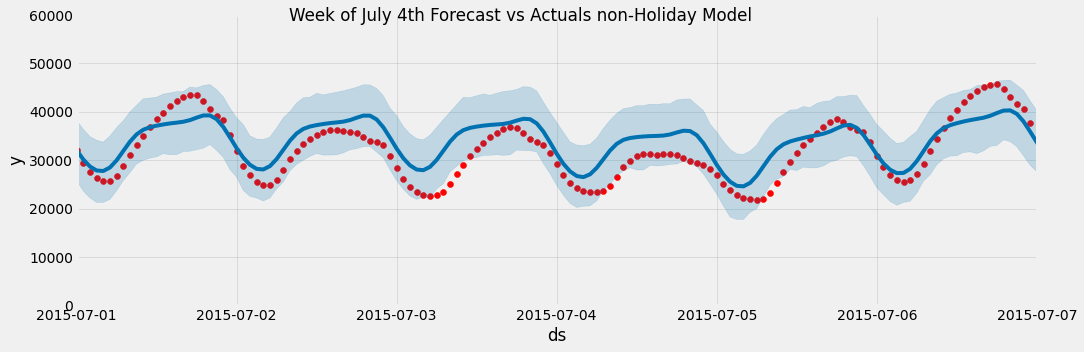

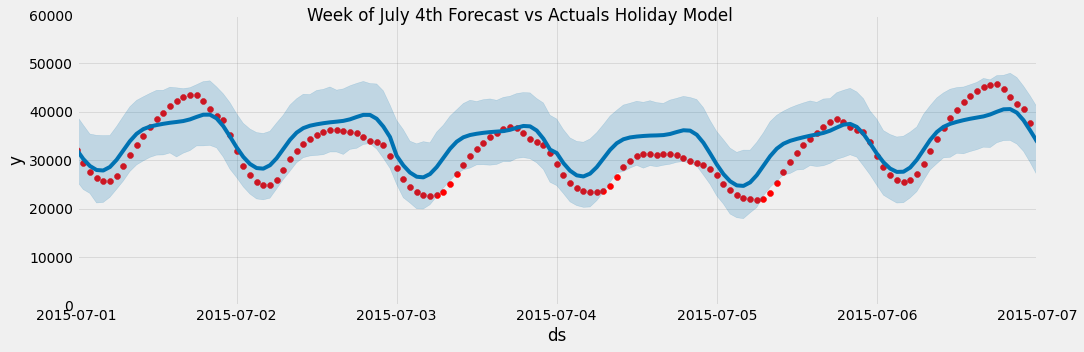

## Compare Error for just 4th of July
24. Compare MAE for 4th of july over the test set for the holiday model and non holiday model

The MAE on the test set for the non-holiday model is : 
 2031.8095120087262


The MAE on the test set for the holiday model is : 
 2027.1718380381146


# Error of all Holidays
25. Now compare the mae for all holidays, do you notice anything unexpected ?

The MAE on the test set fot the non holiday model is : 
 5496.3643179649935


The MAE on the test set for the holiday model is : 
 5612.940892673396


# Plot Error of Each Forecast
26. Plot the forecast against the target variable for each model on the test set, what do you notice? Are there any observable phenomenon that the model is struggling to predict ?

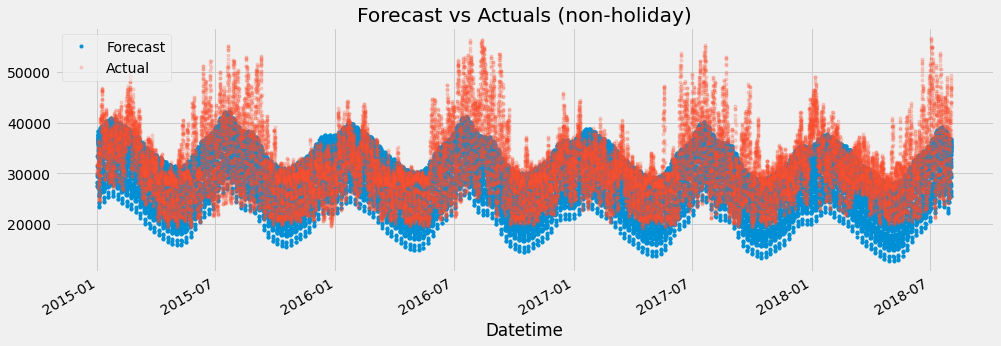

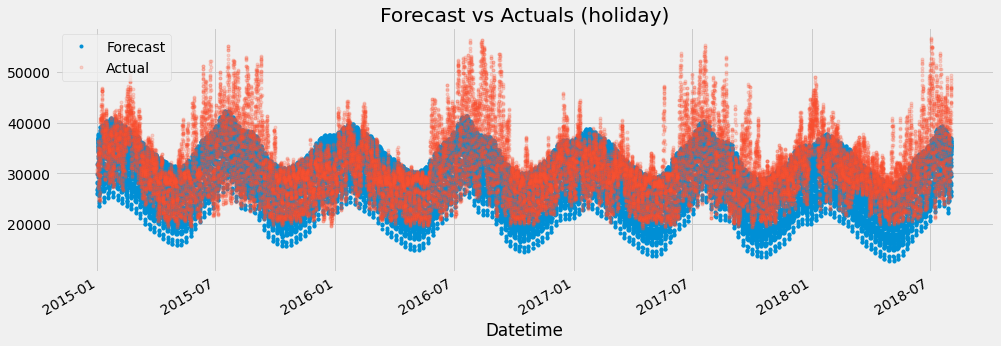